# Predicting Emojis in Tweets

### Assignment

The task is to build a predictive model of emoji in a given piece of text. Our suggestion is to use standard vectorization methods and machine learning classifiers (of your choice). Prepare a script for conducting the experiment, an instruction to reproduce your experiment results, and a report that includes the following:

- Experiment results, including the standard metrics e.g. precisions, accuracies, f-measures, and confusion matrices (if applicable).

- Your findings and observations are based on the experiments, including limitations and assumptions.

- How you choose the vectorization method and algorithms.

- What the experiments may be useful for and how we may improve their utility of it.

### Data Description

Included in this repository are two files:

- *tweets.txt*, where each line includes the text of a tweet that included emoji (but the emoji has been removed);

- *emoji.txt*, where each line includes the name of the emoji for the corresponding text in tweets.txt.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import pathlib
import random
import re
from collections import Counter

import warnings
warnings.filterwarnings('ignore')


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [4]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Embedding, Input, LSTM, Dense, Permute, Multiply, Lambda, Concatenate, Embedding, RepeatVector
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

2024-04-30 04:08:42.444136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from gensim.parsing import preprocessing

In [6]:
from aws.aws_funcs import upload_to_s3

## Functions

#### Visualization

In [7]:
def plot_loss_curves(history, metrics='accuracy'):
  """
  Plots training and validation loss curves, as well as accuracy (or other specified metric) curves for a model's training history.

  This function takes the history object returned by a model's fit method in Keras/TensorFlow and plots both the training and 
  validation loss over epochs, as well as the training and validation accuracy (or another specified metric). This is useful 
  for visualizing the model's learning process and identifying issues like overfitting or underfitting.

  Parameters:
  - history: A Keras History object. This object is returned by the fit method of models in Keras and contains the loss and 
    metric values from training.
  - metrics (str, optional): The name of the metric to plot alongside loss. Defaults to 'accuracy'.
  """

  # sourcery skip: extract-duplicate-method
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history[metrics]
  val_accuracy = history.history[f'val_{metrics}']

  epochs = range(1, 1 + len(history.history['loss']))

  fig, ax = plt.subplots(1, 2, figsize=(15, 4), dpi=200)

  ax[0].plot(epochs, loss, label='training_loss')
  ax[0].plot(epochs, val_loss, label='val_loss')
  ax[0].set_title('loss')
  ax[0].set_xlabel('epochs')
  ax[0].legend()

  ax[1].plot(epochs, accuracy, label=f'training_{metrics}')
  ax[1].plot(epochs, val_accuracy, label=f'val_{metrics}')
  ax[1].set_title(metrics)
  ax[1].set_xlabel('epochs')
  ax[1].legend()

#### Preprocessing

In [8]:
def preprocess_tweet_text(tweet_text: str) -> str:
    """
    Preprocesses a tweet's text for NLP tasks by cleaning and normalizing the text.

    This function applies a series of preprocessing steps to clean and normalize tweet text, making it more suitable for 
    natural language processing (NLP) tasks. The steps include stripping non-alphanumeric characters, reducing multiple 
    whitespaces to a single whitespace, removing punctuation, stripping numeric characters, stemming the text to reduce 
    words to their root form, and removing stopwords to eliminate common but uninformative words.

    Parameters:
    - tweet_text (str): The text of the tweet to be preprocessed.

    Returns:
    - str: The preprocessed and normalized tweet text.
    """

    preprocessed_text = preprocessing.strip_non_alphanum(s=tweet_text)
    preprocessed_text = preprocessing.strip_multiple_whitespaces(s=preprocessed_text)
    preprocessed_text = preprocessing.strip_punctuation(s=preprocessed_text)
    preprocessed_text = preprocessing.strip_numeric(s=preprocessed_text)

    preprocessed_text = preprocessing.stem_text(text=preprocessed_text)
    preprocessed_text = preprocessing.remove_stopwords(s=preprocessed_text)

    return preprocessed_text


In [9]:
def to_dataset(features, labels, BATCH_SIZE=32):
    """
    Converts features and labels into a TensorFlow dataset with batching and prefetching.

    This function takes features and labels, converts them into TensorFlow datasets, and then combines them into a single dataset. 
    The combined dataset is shuffled, batched, and prefetched for optimal training performance. This is particularly useful for 
    preparing data for model training in TensorFlow, allowing for efficient data loading and processing.

    Parameters:
    - features (array-like): Input features for the model. Can be a list, NumPy array, or similar structures.
    - labels (array-like): Corresponding labels for the input features.
    - BATCH_SIZE (int, optional): The size of the batches of data. Defaults to 32.

    Returns:
    - dataset (tf.data.Dataset): A TensorFlow Dataset object ready for model training, including features and labels, shuffled 
    and batched.

    Note: Requires TensorFlow to be imported as tf. 'tf.data.experimental.AUTOTUNE' is used to allow TensorFlow to dynamically 
    adjust the number of elements to prefetch based on the system's current state, improving runtime efficiency.
    """
    
    dataset_features = tf.data.Dataset.from_tensor_slices(features)
    dataset_labels = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((dataset_features, dataset_labels))
    dataset = dataset.shuffle(buffer_size=len(features)).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

#### Model Metrics

In [10]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  ----
  y_true = true labels in the form of a 1D array
  y_pred = predicted label in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall and f1-score between y_true and y_pred.
  """

  model_accuracy = accuracy_score(y_true, y_pred) * 100 # get accuracy score in percentage value
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  return {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1,
  }

#### Amazon S3

In [11]:
path_to_local_plots = 'path/to/plots/'
def upload_to_aws_png(file_name):
    upload_to_s3(f'{path_to_local_plots}{file_name}.png', f'path/to/plots/{file_name}.png')

def upload_plot(plot_name):
    plt.savefig(f'{path_to_local_plots}{plot_name}.png', dpi=300)
    upload_to_aws_png(plot_name)

In [12]:
path_to_local_csv = 'path/to/csv/'
def upload_to_aws_csv(file_name):
    upload_to_s3(f'{path_to_local_csv}{file_name}.csv', f'path/to/csv/{file_name}.csv')

def upload_csv(df, csv_name):
    df.to_csv(f'{path_to_local_csv}{csv_name}.csv', index=False)
    upload_to_aws_csv(csv_name)

## Get Data and Become One with It

In [13]:
path_emoji = pathlib.Path('data/emoji.txt')
path_tweets = pathlib.Path('data/tweets.txt')

In [14]:
with open(path_emoji.__str__(), 'r', encoding='utf-8') as file:
    lines = [elem.replace('\n', '') for elem in file.readlines()]

emoji_df = pd.DataFrame(lines, columns=['Tweets'])
emoji_df

,Tweets
0,heart_eyes
1,yum
2,sob
3,blush
4,sob
...,...
225326,grin
225327,sob
225328,wink
225329,sob


In [ ]:
upload_csv(emoji_df['Tweets'], 'raw_emoji')

In [15]:
type(emoji_df.value_counts())

pandas.core.series.Series

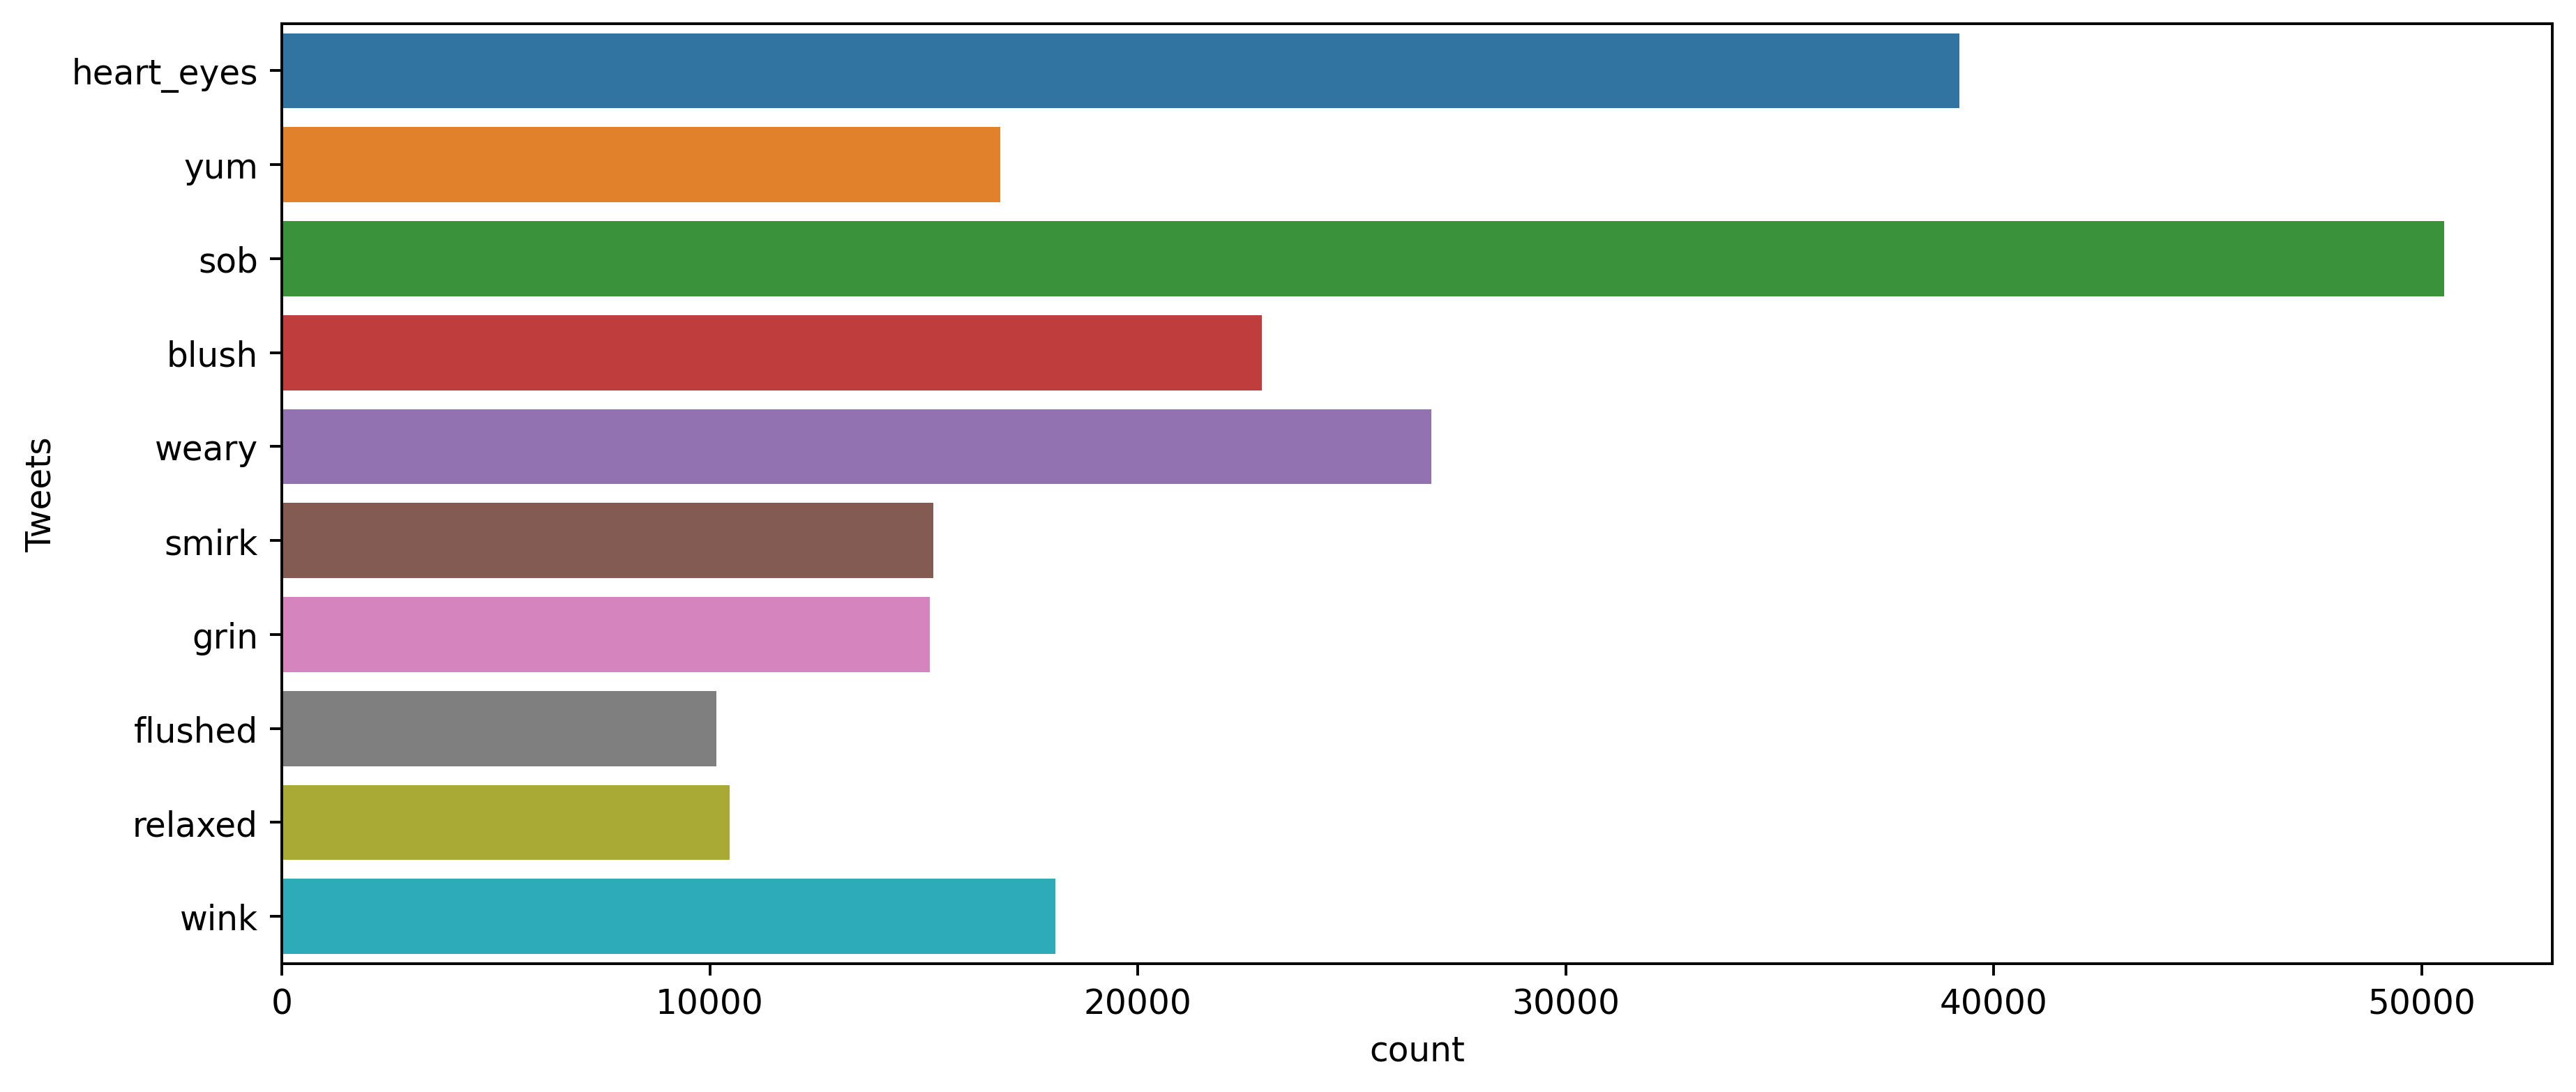

In [16]:
plt.figure(figsize=(12, 5), dpi=350)
sns.countplot(data=emoji_df, y='Tweets');

# upload_plot('1_categories_count')

In [17]:
# sourcery skip: dict-comprehension
emoji_df.value_counts().max() / emoji_df.value_counts().min()
ratio_max_others = {}
for idx in emoji_df.value_counts().index:
    ratio_max_others[f'Sob to {idx[0]}'] = (emoji_df.value_counts().loc[["sob"]] / emoji_df.value_counts().loc[idx]).to_list()[0]

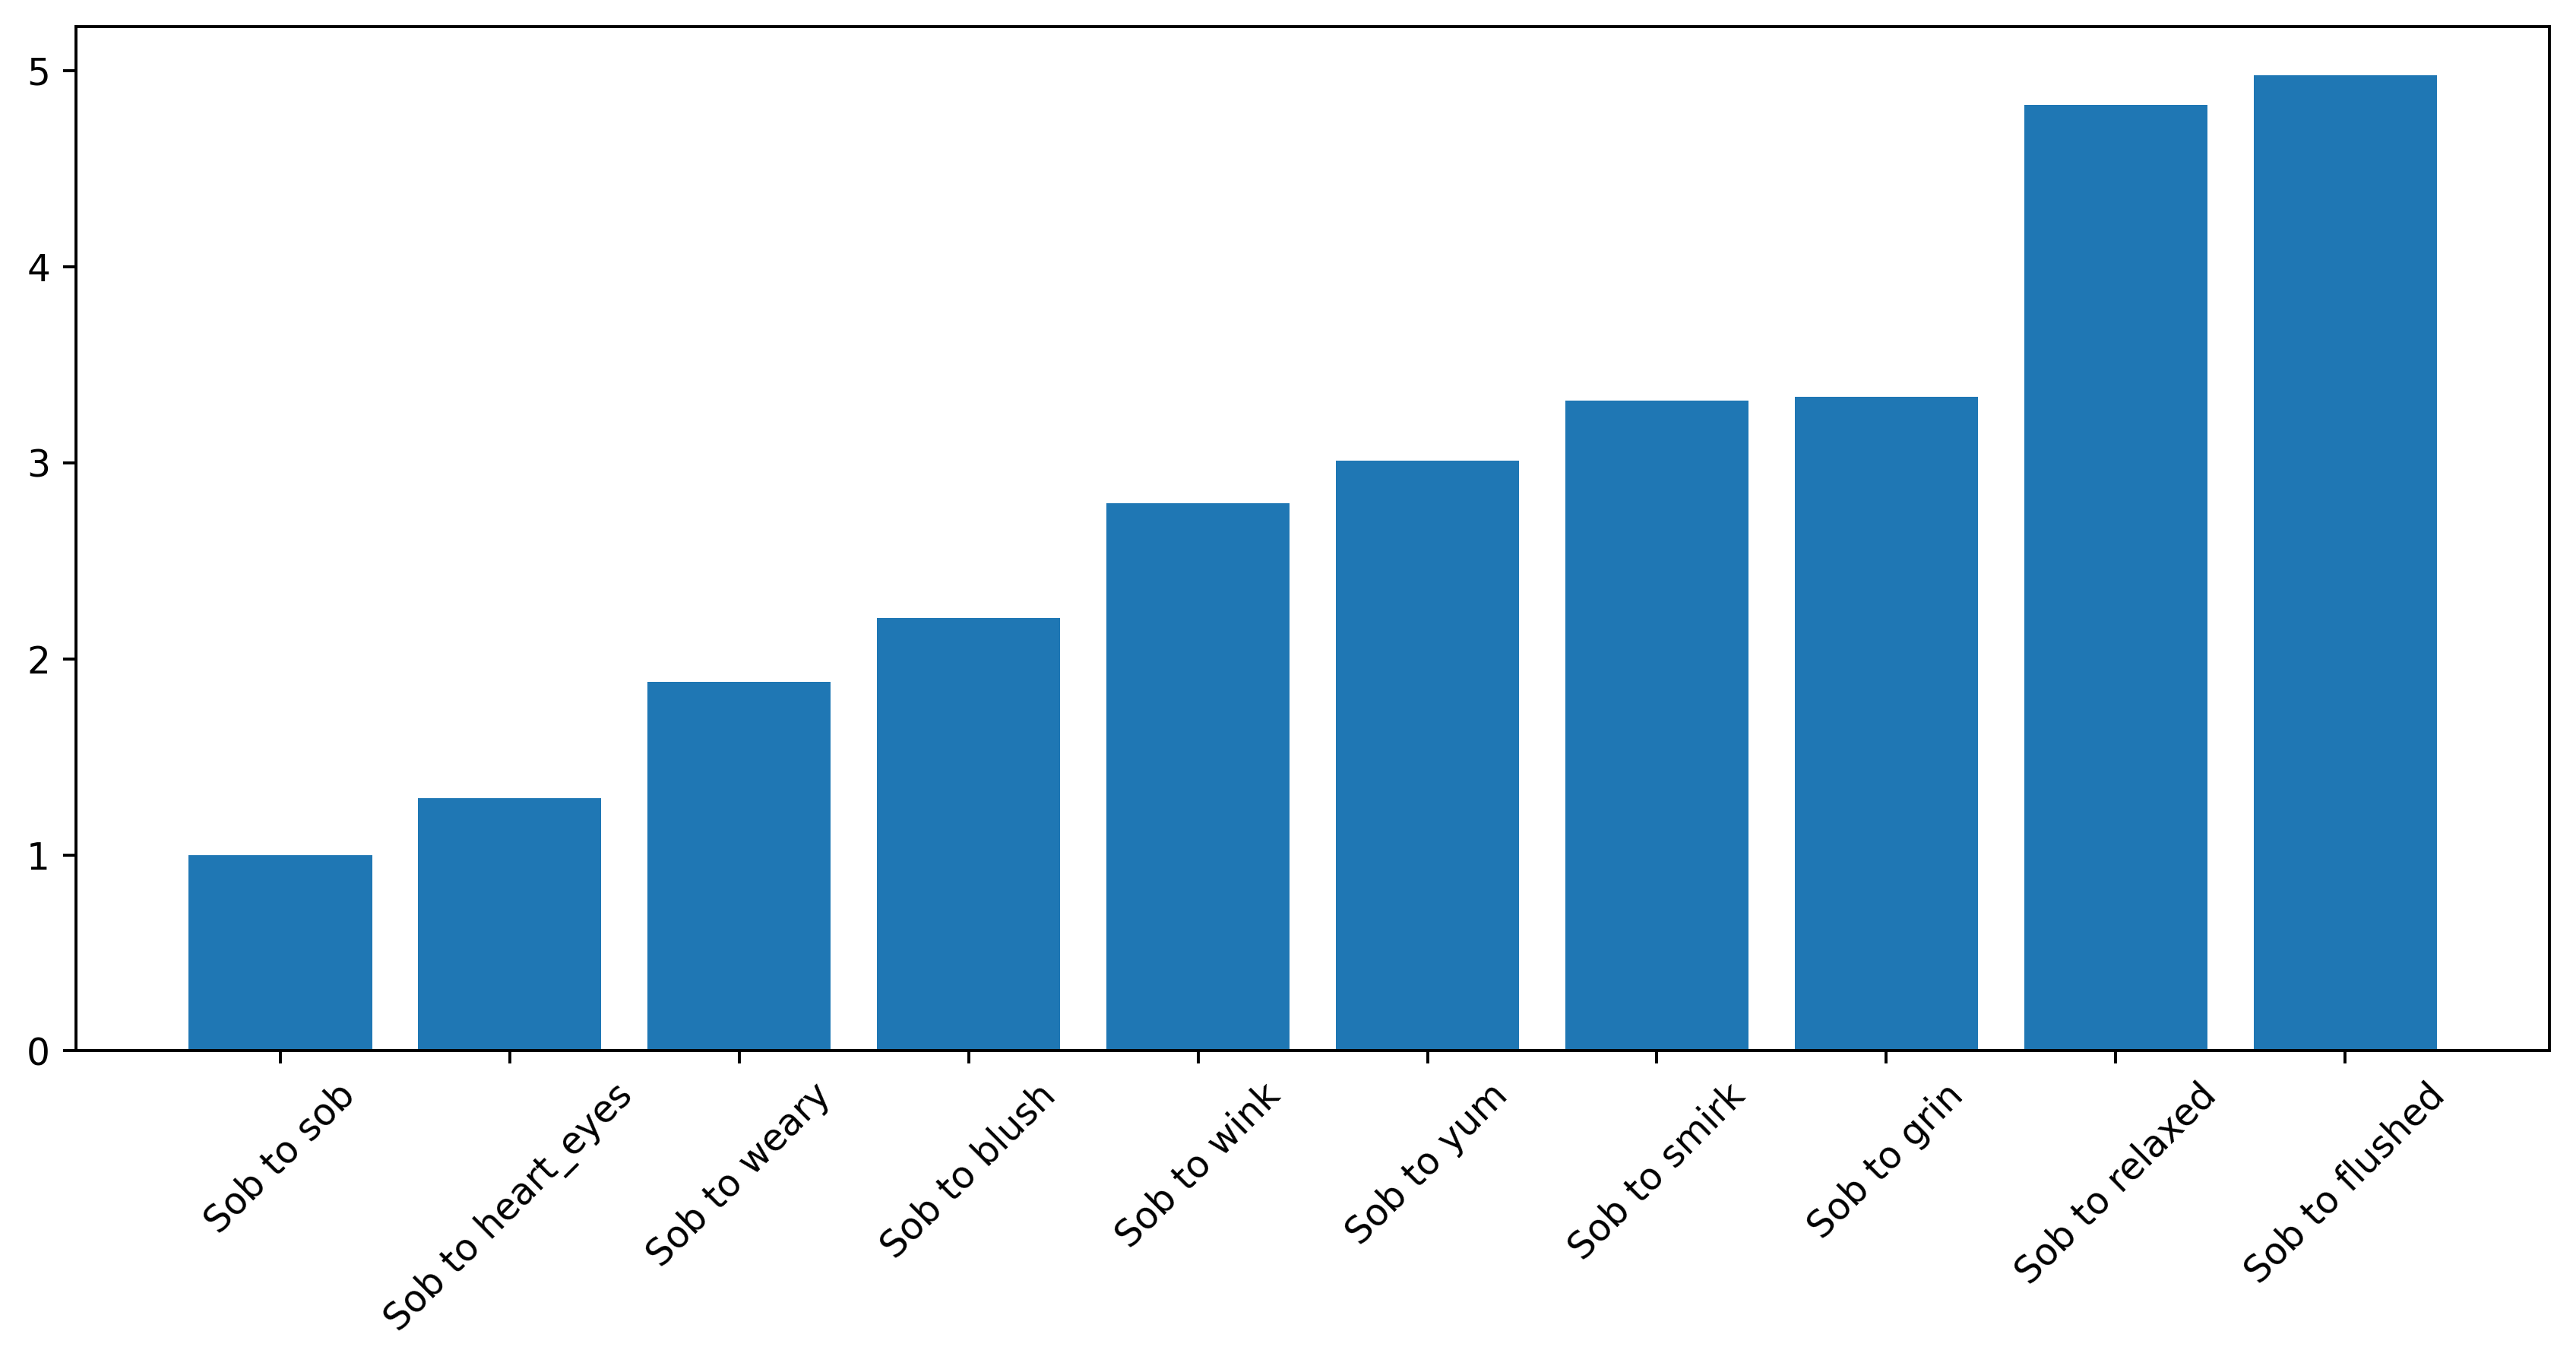

In [19]:
plt.figure(figsize=(12, 5), dpi=350)
plt.xticks(rotation=45)
plt.bar(ratio_max_others.keys(), ratio_max_others.values());
# upload_plot('2_unbalanced_check')

We see that the data is a little unbalanced with maximum ration 5. We'll see later if it affects the predictions and probably will try to fix it.

In [20]:
with open(path_tweets.__str__(), 'r', encoding='utf-8') as file:
    lines = [elem.replace('\n', '') for elem in file.readlines()]

tweets_df = pd.DataFrame(lines, columns=['Tweets'])
tweets_df

,Tweets
0,RT @VibingOverHoes: Bet you'll get hungry htt...
1,Starbucks employee confuses boyfriend by sayin...
2,When your Starbucks store makes you an iced mo...
3,"Being told ""girl your romper looks fierce!"" At..."
4,"I got a Starbucks drink at school today, shit ..."
...,...
225326,RT @TheFunnyVine: She broke down as soon as sh...
225327,@PinKC0ttNkandi_ Mines shorter than yours Lls ...
225328,@BenColeyGolf was yours the 5k bet on US earli...
225329,@Kevyn_Brown @BurgerKing come on leek i gotta ...


In [ ]:
upload_csv(tweets_df, 'raw_tweets')

Text(0, 0.5, 'Count')

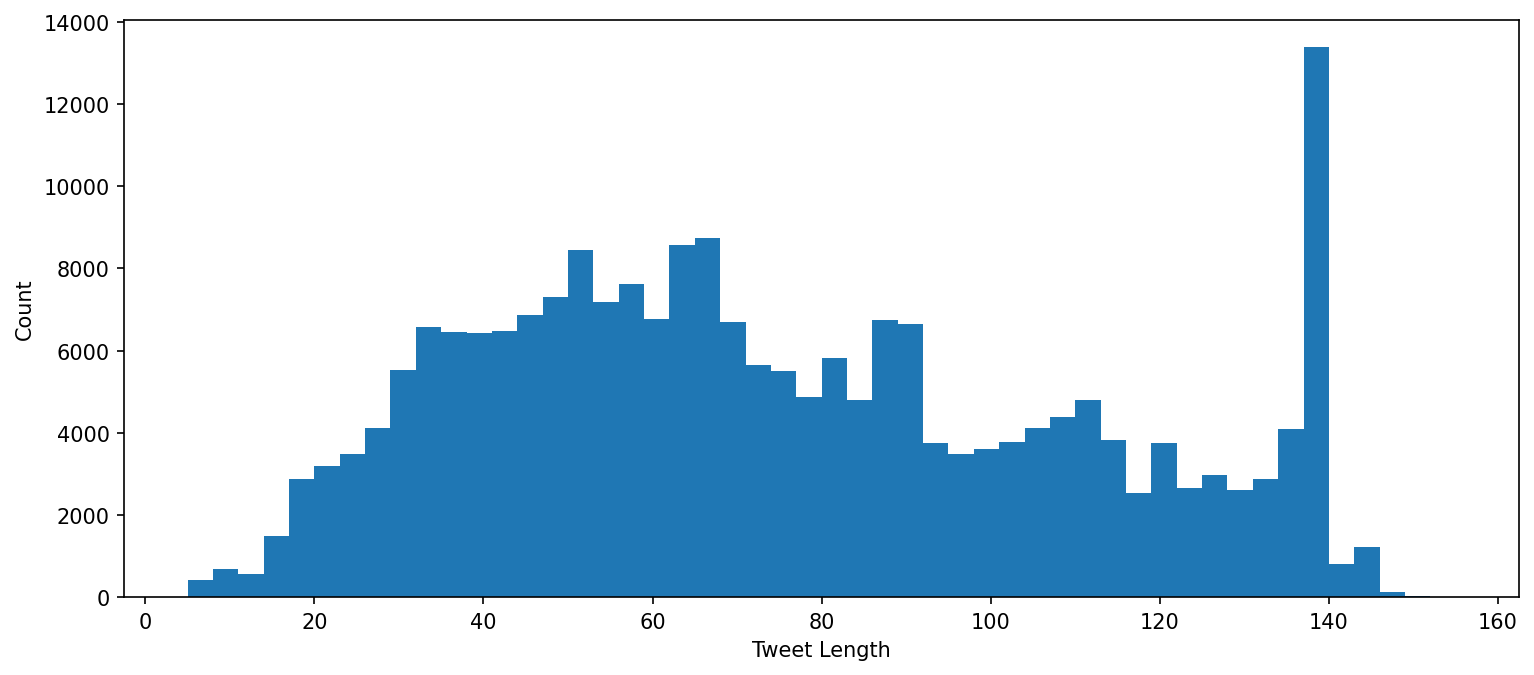

In [21]:
plt.figure(figsize=(12, 5), dpi=150)
plt.hist(tweets_df['Tweets'].apply(lambda x: len(x)), bins= 50);
plt.xlabel('Tweet Length')
plt.ylabel('Count')
# upload_plot('Tweets_Length_Distribution')

In [22]:
tweets_df['tweets_preprocessed'] = tweets_df['Tweets'].apply(preprocess_tweet_text)

In [23]:
tweets_df

,Tweets,tweets_preprocessed
0,RT @VibingOverHoes: Bet you'll get hungry htt...,rt vibingoverho bet ll hungri http t hoouxpmvq
1,Starbucks employee confuses boyfriend by sayin...,starbuck employe confus boyfriend sai peni tall
2,When your Starbucks store makes you an iced mo...,starbuck store ic mocha instead white mocha
3,"Being told ""girl your romper looks fierce!"" At...",told girl romper look fierc subwai todai happi...
4,"I got a Starbucks drink at school today, shit ...",got starbuck drink school todai shit tast sooo...
...,...,...
225326,RT @TheFunnyVine: She broke down as soon as sh...,rt thefunnyvin broke soon heard starbuck http ...
225327,@PinKC0ttNkandi_ Mines shorter than yours Lls ...,pinkcttnkandi shorter ll bet start curl wa bou...
225328,@BenColeyGolf was yours the 5k bet on US earli...,bencoleygolf wa k bet earlier todai
225329,@Kevyn_Brown @BurgerKing come on leek i gotta ...,kevyn brown burgerk come leek gotta onc


In [ ]:
upload_csv(tweets_df, 'preprocessed_tweets')

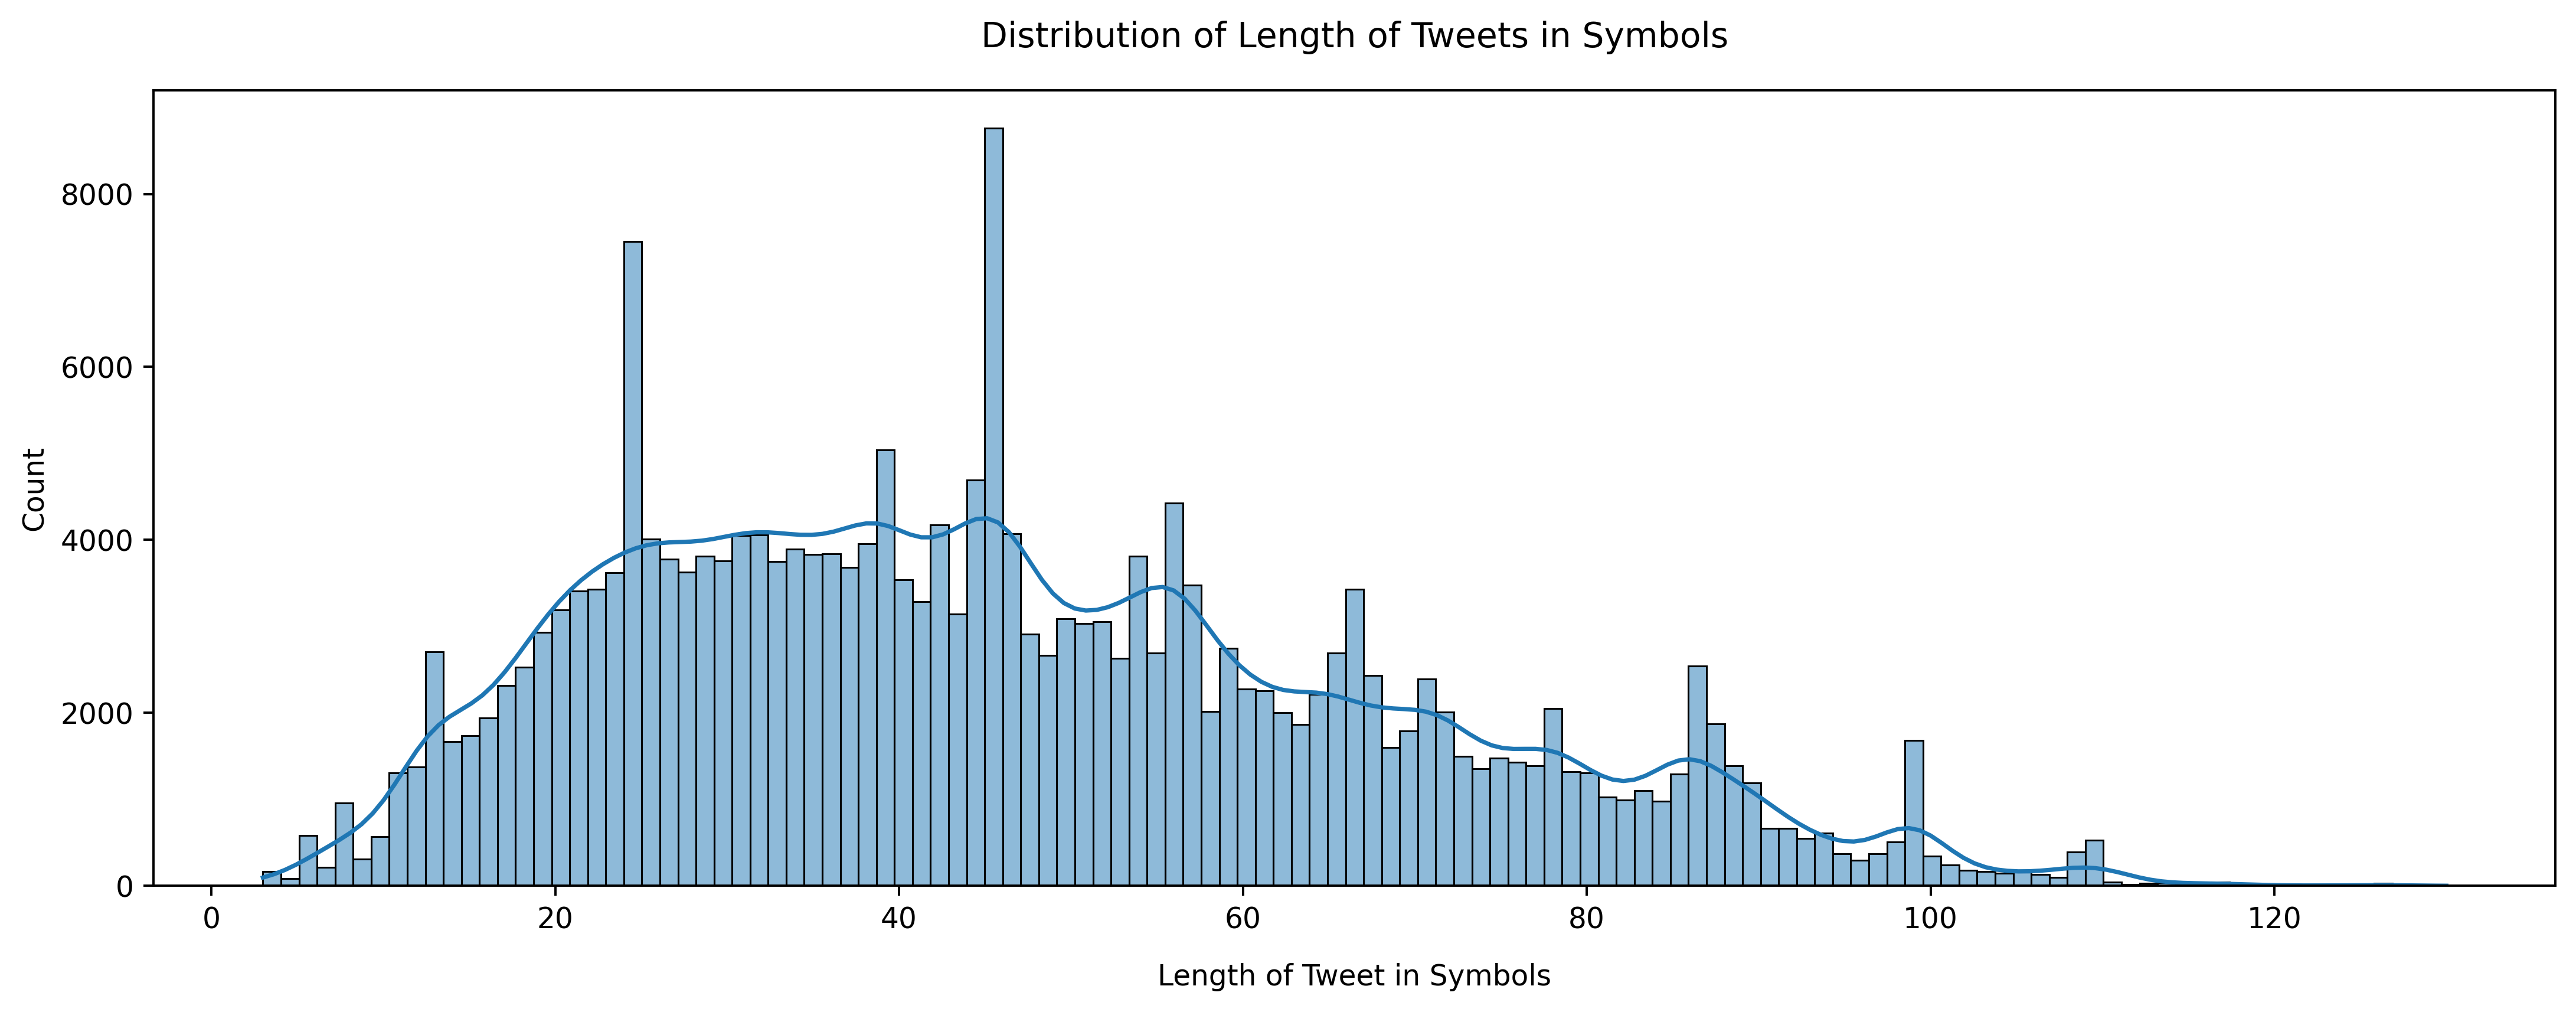

In [24]:
plt.figure(figsize=(15, 5), dpi=350)
sns.histplot(data=tweets_df, x=tweets_df['tweets_preprocessed'].apply(len), kde=True)
plt.xlabel('Length of Tweet in Symbols', labelpad=10)
plt.title('Distribution of Length of Tweets in Symbols', pad=15);
# upload_plot('Tweet_Length_Symbols_Distribution')

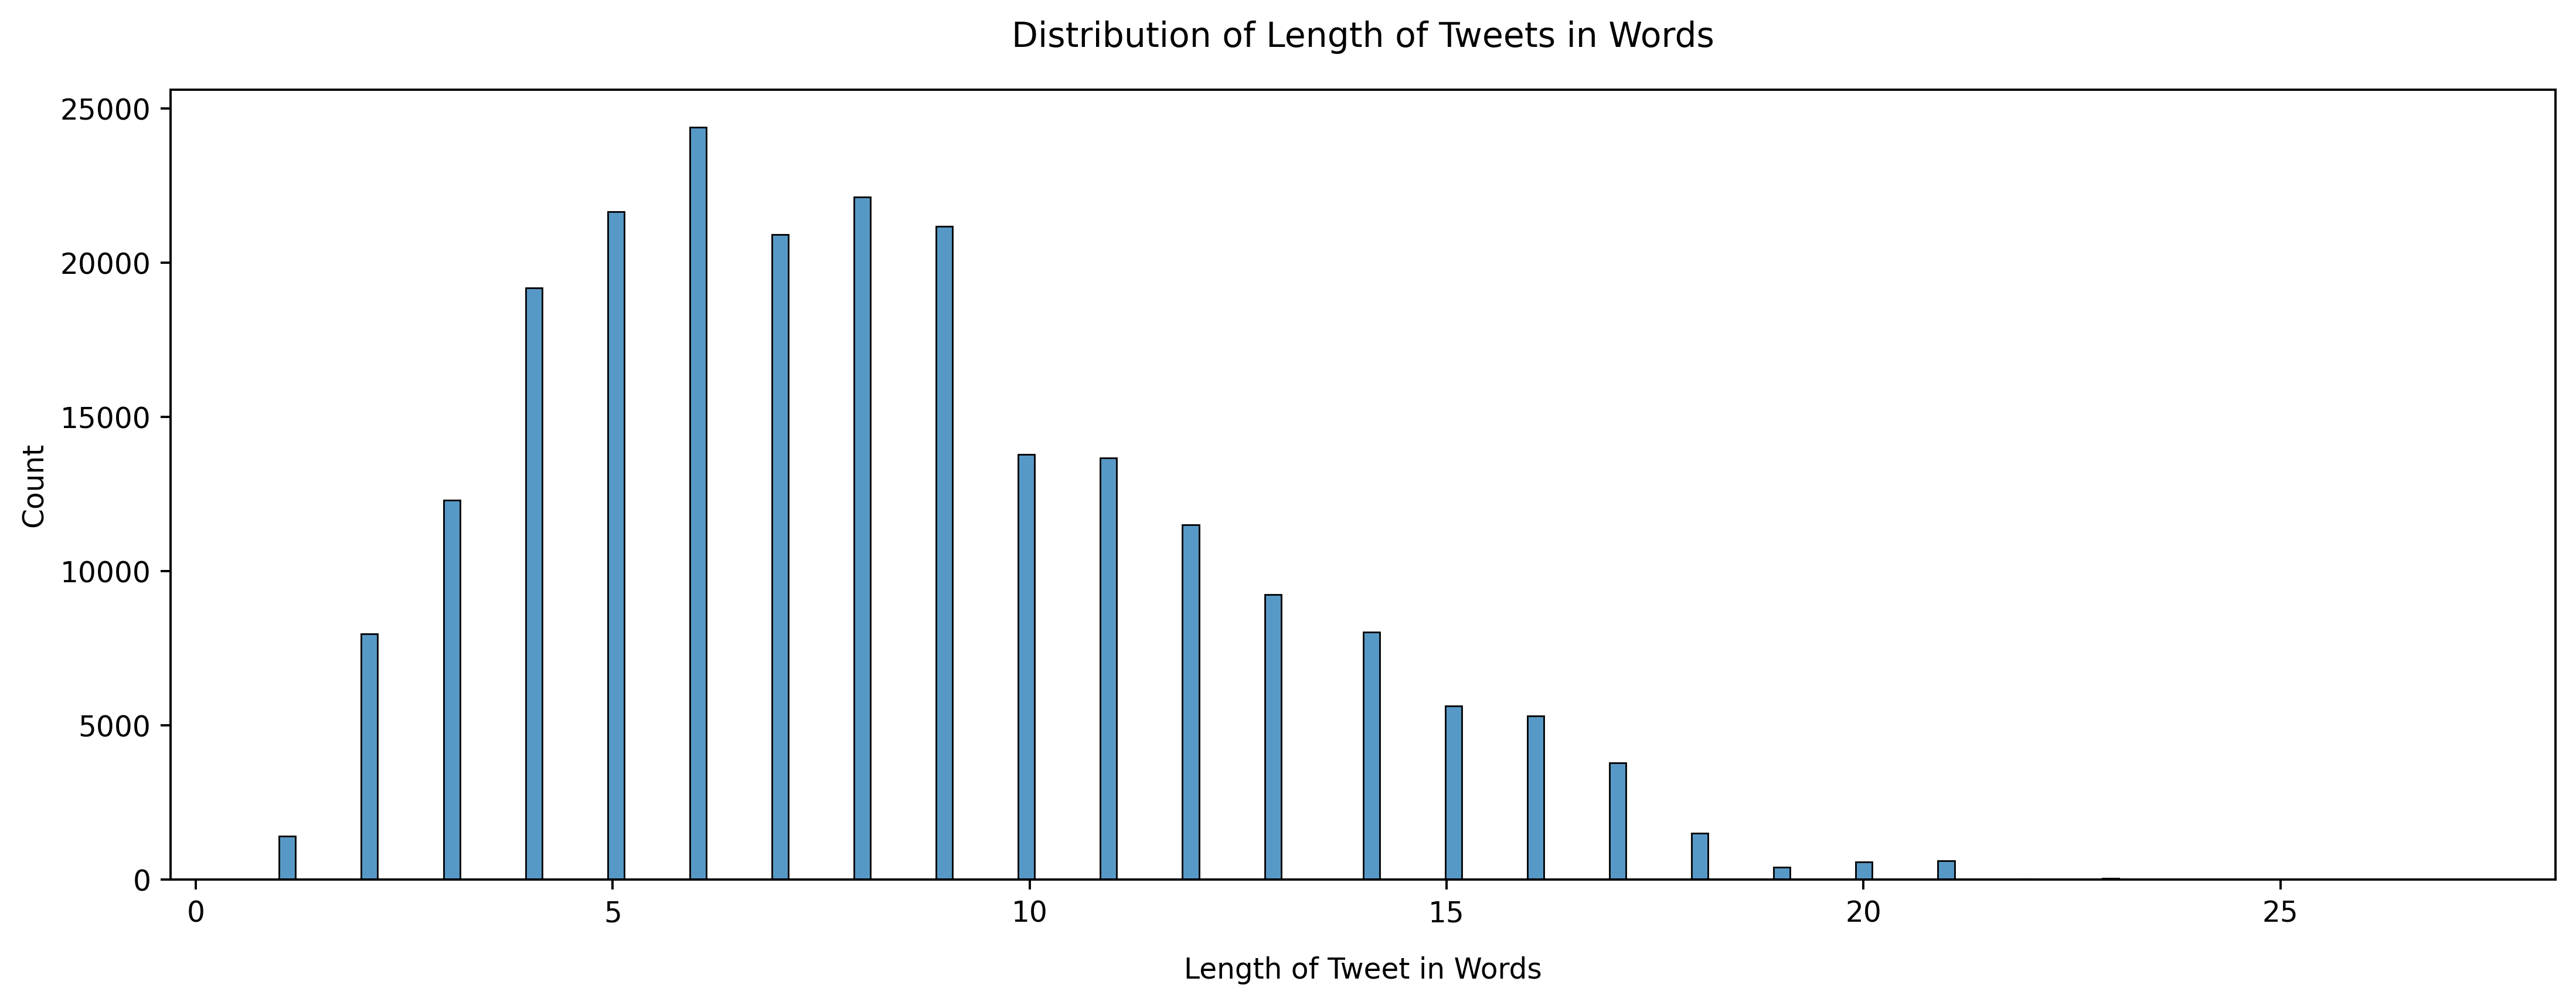

In [25]:
plt.figure(figsize=(15, 5), dpi=350)
sns.histplot(data=tweets_df, x=tweets_df['tweets_preprocessed'].apply(lambda x: x.split(' ')).apply(len))
plt.xlabel('Length of Tweet in Words', labelpad=10)
plt.title('Distribution of Length of Tweets in Words', pad=15);
# upload_plot('Tweet_Length_Words_Distribution')

## Split Data into Training and Validation Sets

In [26]:
encoder = OrdinalEncoder()
emoji_df['encoded'] = encoder.fit_transform(emoji_df[['Tweets']])
emoji_df

,Tweets,encoded
0,heart_eyes,3.0
1,yum,9.0
2,sob,6.0
3,blush,0.0
4,sob,6.0
...,...,...
225326,grin,2.0
225327,sob,6.0
225328,wink,8.0
225329,sob,6.0


In [27]:
label2id = dict(zip(encoder.categories_[0], iter(range(10))))
id2label = dict(zip(iter(range(10)), encoder.categories_[0]))
pd.Series(id2label)

0         blush
1       flushed
2          grin
3    heart_eyes
4       relaxed
5         smirk
6           sob
7         weary
8          wink
9           yum
dtype: object

In [29]:
upload_csv(pd.Series(id2label), 'encoding')

In [30]:
tweets_df_final = tweets_df.drop('Tweets', axis=1)
df = pd.merge(emoji_df, tweets_df_final, left_index=True, right_index=True).rename(columns={'encoded': 'emoji', 'tweets_preprocessed': 'tweets'}).drop('Tweets', axis=1)
df.head()

,emoji,tweets
0,3.0,rt vibingoverho bet ll hungri http t hoouxpmvq
1,9.0,starbuck employe confus boyfriend sai peni tall
2,6.0,starbuck store ic mocha instead white mocha
3,0.0,told girl romper look fierc subwai todai happi...
4,6.0,got starbuck drink school todai shit tast sooo...


In [31]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    df['tweets'],
    df['emoji'],
    test_size=0.2,
    random_state=42
)

In [ ]:
upload_csv(df.head(), 'head_final_df')

## Converting Text into Numbers

In [32]:
text_vectorizer = TextVectorization(
    max_tokens=15_000,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=30,
    pad_to_max_tokens=True
)
text_vectorizer.adapt(train_sentences)

In [33]:
# Example of how does it work
sample_sentence = "There's a flood in my street"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[   1,    1, 3554,    1,    1,  936,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]])>

In [34]:
# Get Vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_10_words = words_in_vocab[:10]
bottom_10_words = words_in_vocab[-10:]
print(f'Most common words in vocab: {top_10_words}')
print(f'Least common words in vocab: {bottom_10_words}')

Most common words in vocab: ['', '[UNK]', 't', 'bet', 'http', 'rt', 'starbuck', 's', 'thi', 'subwai']
Least common words in vocab: ['soror', 'sorchahollowai', 'sophiaeatspizza', 'sopandeb', 'soooooooooooooo', 'sooooooooo', 'soonyoung', 'soojung', 'sony', 'soniabubla']


## Creating an Embedding using an Embedding Layer

In [35]:
embedding = layers.Embedding(
    input_dim=15_000,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=30
)

embedding

## Models

### Model 0

In [36]:
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [37]:
baseline_score = model_0.score(test_sentences, test_labels)
f'Baseline Model achieves an accuracy of: {baseline_score * 100:.2f}%'

'Baseline Model achieves an accuracy of: 44.20%'

## Tensorflow Models

### Preparing For Training

##### Data to Dataset

In [38]:
train_sentences_vectorized = text_vectorizer(train_sentences)
test_sentences_vectorized = text_vectorizer(test_sentences)

In [39]:
dataset_train = to_dataset(train_sentences_vectorized, train_labels)
dataset_test = to_dataset(test_sentences_vectorized, test_labels)

#### Callbacks

In [40]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

### Model 1: LSTM

In [41]:
inputs = layers.Input(shape=(30,), dtype="int32")
x = embedding(inputs)
x = layers.LSTM(64, activation="tanh")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_LSTM")

model_1.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(dataset_train,
                        epochs=5,
                        validation_data=dataset_test)

Epoch 1/5


2024-04-30 04:12:12.369326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 04:12:12.370912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 04:12:12.375800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5633/5634 [============================>.] - ETA: 0s - loss: 1.6816 - accuracy: 0.3954

2024-04-30 04:14:16.876314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [45067]
	 [[{{node Placeholder/_2}}]]
2024-04-30 04:14:16.876637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [45067]
	 [[{{node Placeholder/_2}}]]
2024-04-30 04:14:17.251166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

5634/5634 [==============================] - 130s 23ms/step - loss: 1.6816 - accuracy: 0.3954 - val_loss: 1.5371 - val_accuracy: 0.4594
Epoch 2/5
5634/5634 [==============================] - 127s 22ms/step - loss: 1.4437 - accuracy: 0.4933 - val_loss: 1.4865 - val_accuracy: 0.4810
Epoch 3/5
5634/5634 [==============================] - 127s 22ms/step - loss: 1.3565 - accuracy: 0.5238 - val_loss: 1.4659 - val_accuracy: 0.4880
Epoch 4/5
5634/5634 [==============================] - 128s 23ms/step - loss: 1.2861 - accuracy: 0.5484 - val_loss: 1.4681 - val_accuracy: 0.4903
Epoch 5/5
5634/5634 [==============================] - 129s 23ms/step - loss: 1.2204 - accuracy: 0.5714 - val_loss: 1.4908 - val_accuracy: 0.4911


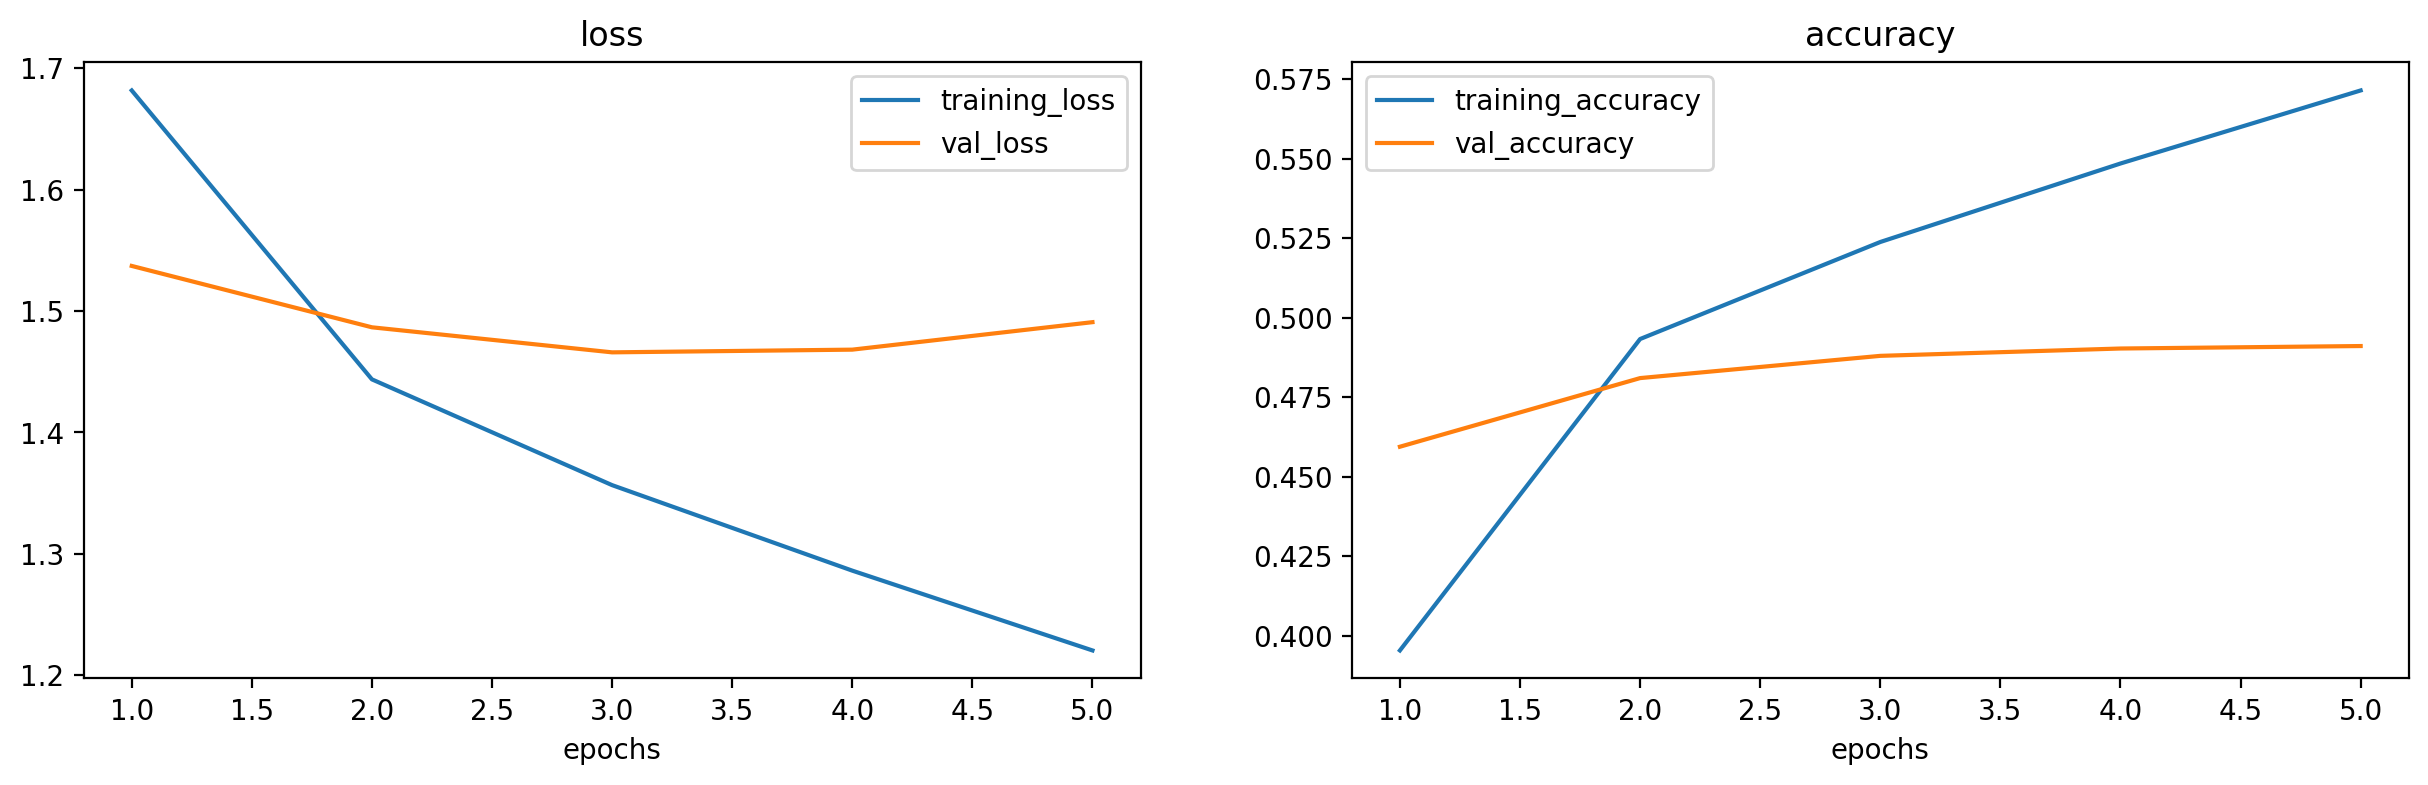

In [42]:
plot_loss_curves(history_1)
# upload_plot('model_1_plot_loss')

### Model 2: Bidirectional

In [43]:
inputs = layers.Input(shape=(30,), dtype="int32")
x = embedding(inputs)
x = layers.Bidirectional(layers.LSTM(64, activation="tanh"))(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_Bidirectional")

model_2.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(dataset_train,
                        epochs=5,
                        validation_data=dataset_test)

2024-04-30 04:23:41.706326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 04:23:41.709305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 04:23:41.711082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2024-04-30 04:23:41.948862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 04:23:41.951799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 04:23:41.955110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5633/5634 [============================>.] - ETA: 0s - loss: 1.3199 - accuracy: 0.5401

2024-04-30 04:26:51.326236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 04:26:51.329858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 04:26:51.331900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5634/5634 [==============================] - 196s 34ms/step - loss: 1.3199 - accuracy: 0.5401 - val_loss: 1.4685 - val_accuracy: 0.4924
Epoch 2/5
5634/5634 [==============================] - 181s 32ms/step - loss: 1.2071 - accuracy: 0.5770 - val_loss: 1.4804 - val_accuracy: 0.4943
Epoch 3/5
5634/5634 [==============================] - 189s 33ms/step - loss: 1.1348 - accuracy: 0.5988 - val_loss: 1.5217 - val_accuracy: 0.4961
Epoch 4/5
5634/5634 [==============================] - 184s 33ms/step - loss: 1.0647 - accuracy: 0.6236 - val_loss: 1.5752 - val_accuracy: 0.4945
Epoch 5/5
5634/5634 [==============================] - 179s 32ms/step - loss: 0.9974 - accuracy: 0.6478 - val_loss: 1.6660 - val_accuracy: 0.4967


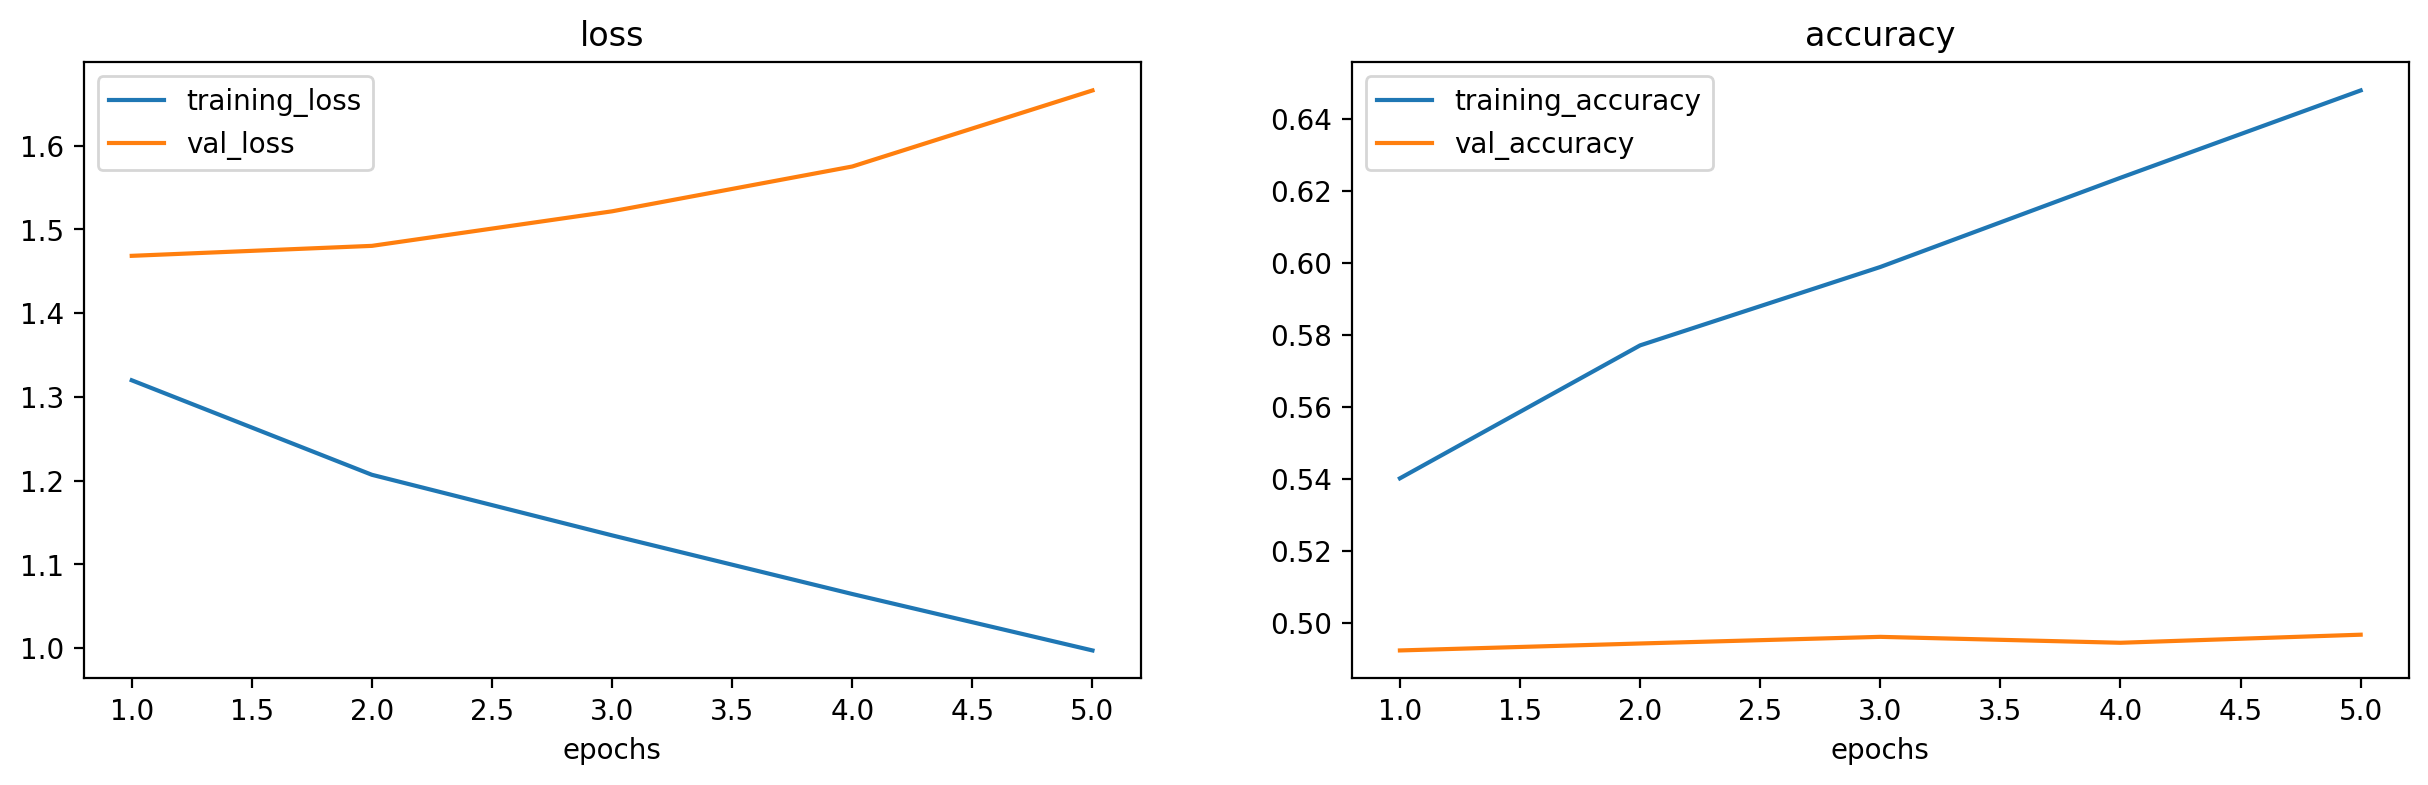

In [44]:
plot_loss_curves(history_2)
# upload_plot('model_2_plot_loss')

### Model 3: Conv1D + Bidirectional

In [45]:
inputs = layers.Input(shape=(30,), dtype="int32")
x = embedding(inputs)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_Conv1D_Bidirectional")

model_3.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_3 = model_3.fit(dataset_train,
                        epochs=5,
                        validation_data=dataset_test)

2024-04-30 04:39:59.382044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 04:39:59.384558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 04:39:59.385995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2024-04-30 04:40:00.072509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 04:40:00.075575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 04:40:00.081869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5634/5634 [==============================] - ETA: 0s - loss: 1.2495 - accuracy: 0.5611

2024-04-30 04:42:34.884247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 04:42:34.887341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 04:42:34.889784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5634/5634 [==============================] - 159s 27ms/step - loss: 1.2495 - accuracy: 0.5611 - val_loss: 1.5504 - val_accuracy: 0.4924
Epoch 2/5
5634/5634 [==============================] - 155s 27ms/step - loss: 1.1091 - accuracy: 0.6081 - val_loss: 1.5705 - val_accuracy: 0.4950
Epoch 3/5
5634/5634 [==============================] - 152s 27ms/step - loss: 1.0061 - accuracy: 0.6440 - val_loss: 1.7155 - val_accuracy: 0.4911
Epoch 4/5
5634/5634 [==============================] - 162s 29ms/step - loss: 0.9091 - accuracy: 0.6781 - val_loss: 1.8264 - val_accuracy: 0.4930
Epoch 5/5
5634/5634 [==============================] - 154s 27ms/step - loss: 0.8157 - accuracy: 0.7104 - val_loss: 2.0082 - val_accuracy: 0.4899


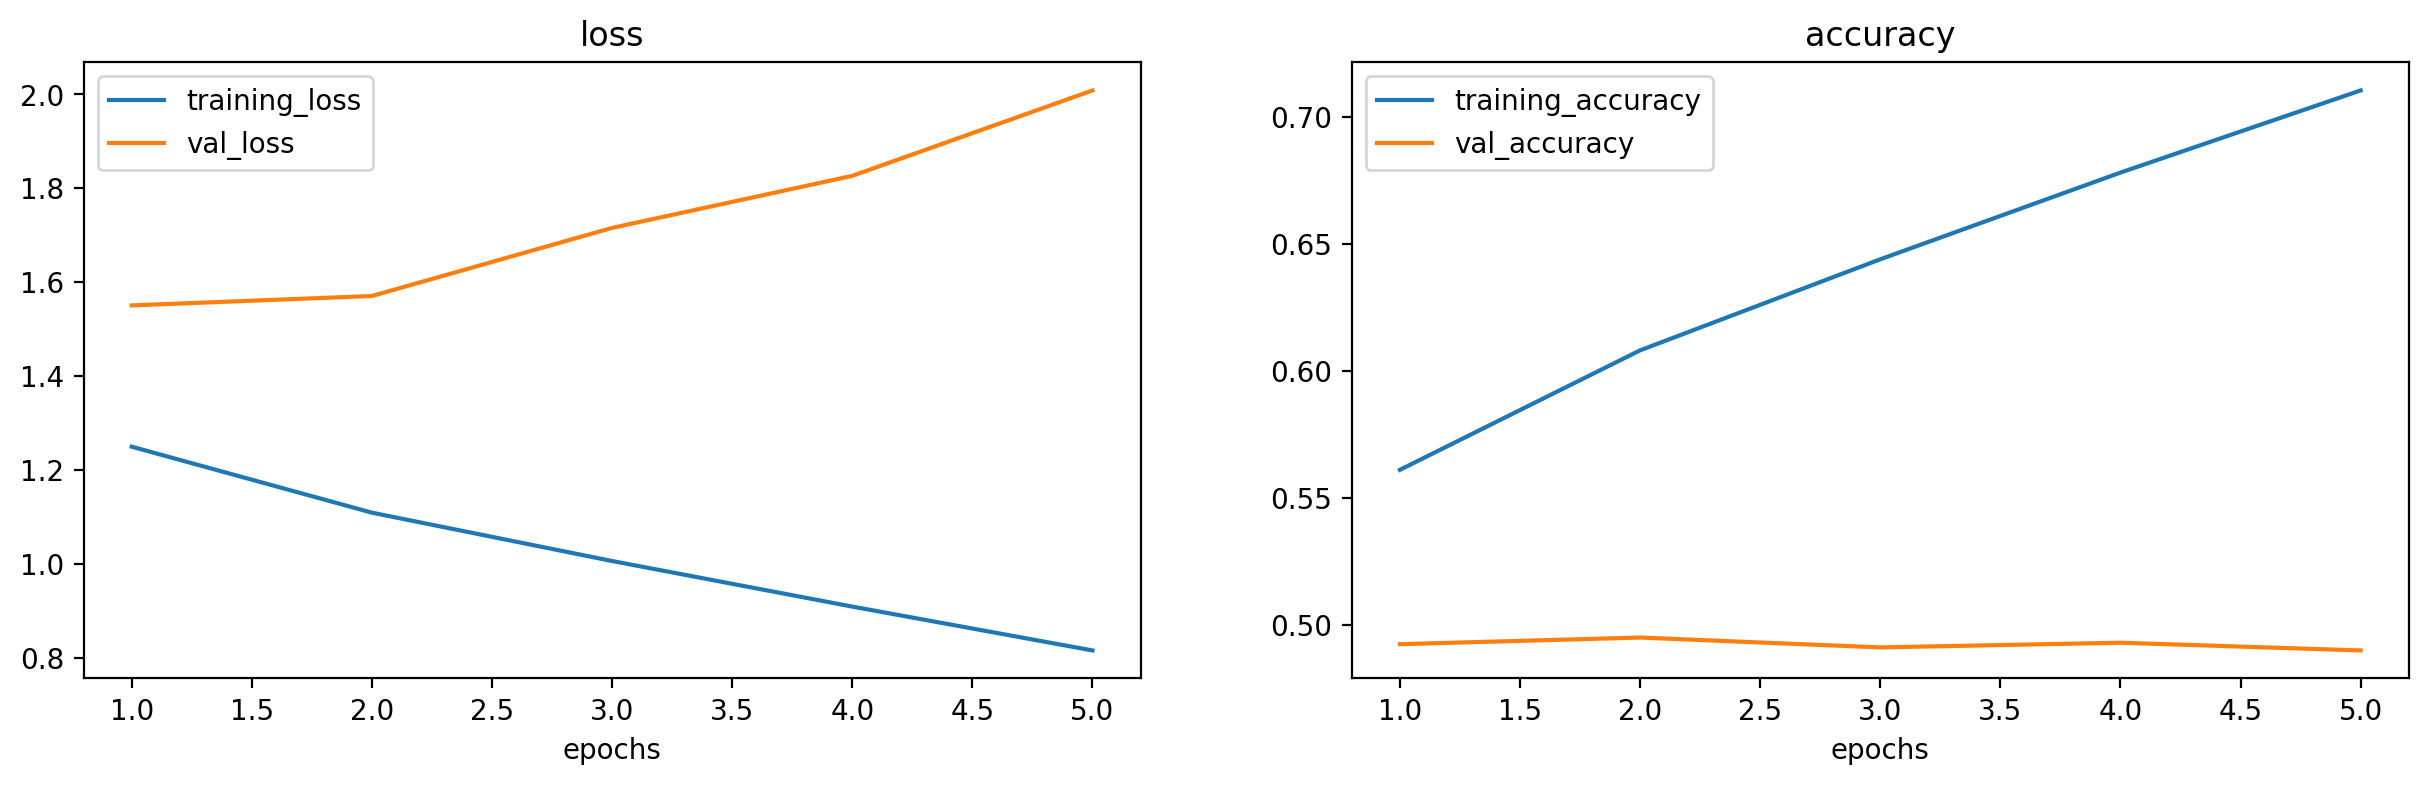

In [46]:
plot_loss_curves(history_3)
# upload_plot('model_3_plot_loss')

### Model 4: Attention

In [47]:
def attention_layer(inputs, SINGLE_ATTENTION_VECTOR=False):
    """
    Implements an attention mechanism layer for a neural network model in Keras.

    This function creates an attention mechanism that can be applied to a sequence input to focus on specific parts of the sequence 
    during training. It works by computing attention probabilities for each token in the input sequence and then applying these 
    probabilities to the input sequence to modulate the importance of each token.

    Parameters:
    - inputs (tensor): A 3D tensor with shape `(batch_size, n_words, shape_embedding_vector)` representing the input sequence.
    - SINGLE_ATTENTION_VECTOR (bool, optional): If True, computes a single attention vector (average across the input sequence) 
    to be applied across all tokens. Defaults to False.

    Returns:
    - A 3D tensor where the attention mechanism has been applied to the input tensor.
    """

    # inputs(batch_size, n_words, shape_embedding_vector)
    num_tokens = K.int_shape(inputs)[1]
    embed_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(num_tokens, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(embed_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    return Multiply()([inputs, a_probs])


inputs = Input(shape=(30, ), dtype='int32')
x = embedding(inputs)  
x = layers.SpatialDropout1D(0.2)(x)
attention_mul = attention_layer(x)
lstm_out = LSTM(64, activation="tanh", dropout=0.3, recurrent_dropout=0.3)(attention_mul)
output = Dense(10, activation='softmax')(lstm_out)
model_4 = Model(inputs=[inputs], outputs=output)

model_4.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_4 = model_4.fit(dataset_train,
                        epochs=12,
                        validation_data=dataset_test,
                        )

Epoch 1/12
5634/5634 [==============================] - 243s 43ms/step - loss: 1.6004 - accuracy: 0.4317 - val_loss: 1.5075 - val_accuracy: 0.4749
Epoch 2/12
5634/5634 [==============================] - 250s 44ms/step - loss: 1.3599 - accuracy: 0.5251 - val_loss: 1.4900 - val_accuracy: 0.4837
Epoch 3/12
5634/5634 [==============================] - 243s 43ms/step - loss: 1.2887 - accuracy: 0.5493 - val_loss: 1.5218 - val_accuracy: 0.4830
Epoch 4/12
5634/5634 [==============================] - 245s 43ms/step - loss: 1.2422 - accuracy: 0.5647 - val_loss: 1.5172 - val_accuracy: 0.4865
Epoch 5/12
5634/5634 [==============================] - 242s 43ms/step - loss: 1.2040 - accuracy: 0.5773 - val_loss: 1.5258 - val_accuracy: 0.4913
Epoch 6/12
5634/5634 [==============================] - 240s 43ms/step - loss: 1.1689 - accuracy: 0.5885 - val_loss: 1.5403 - val_accuracy: 0.4920
Epoch 7/12
5634/5634 [==============================] - 243s 43ms/step - loss: 1.1349 - accuracy: 0.5994 - val_loss: 1

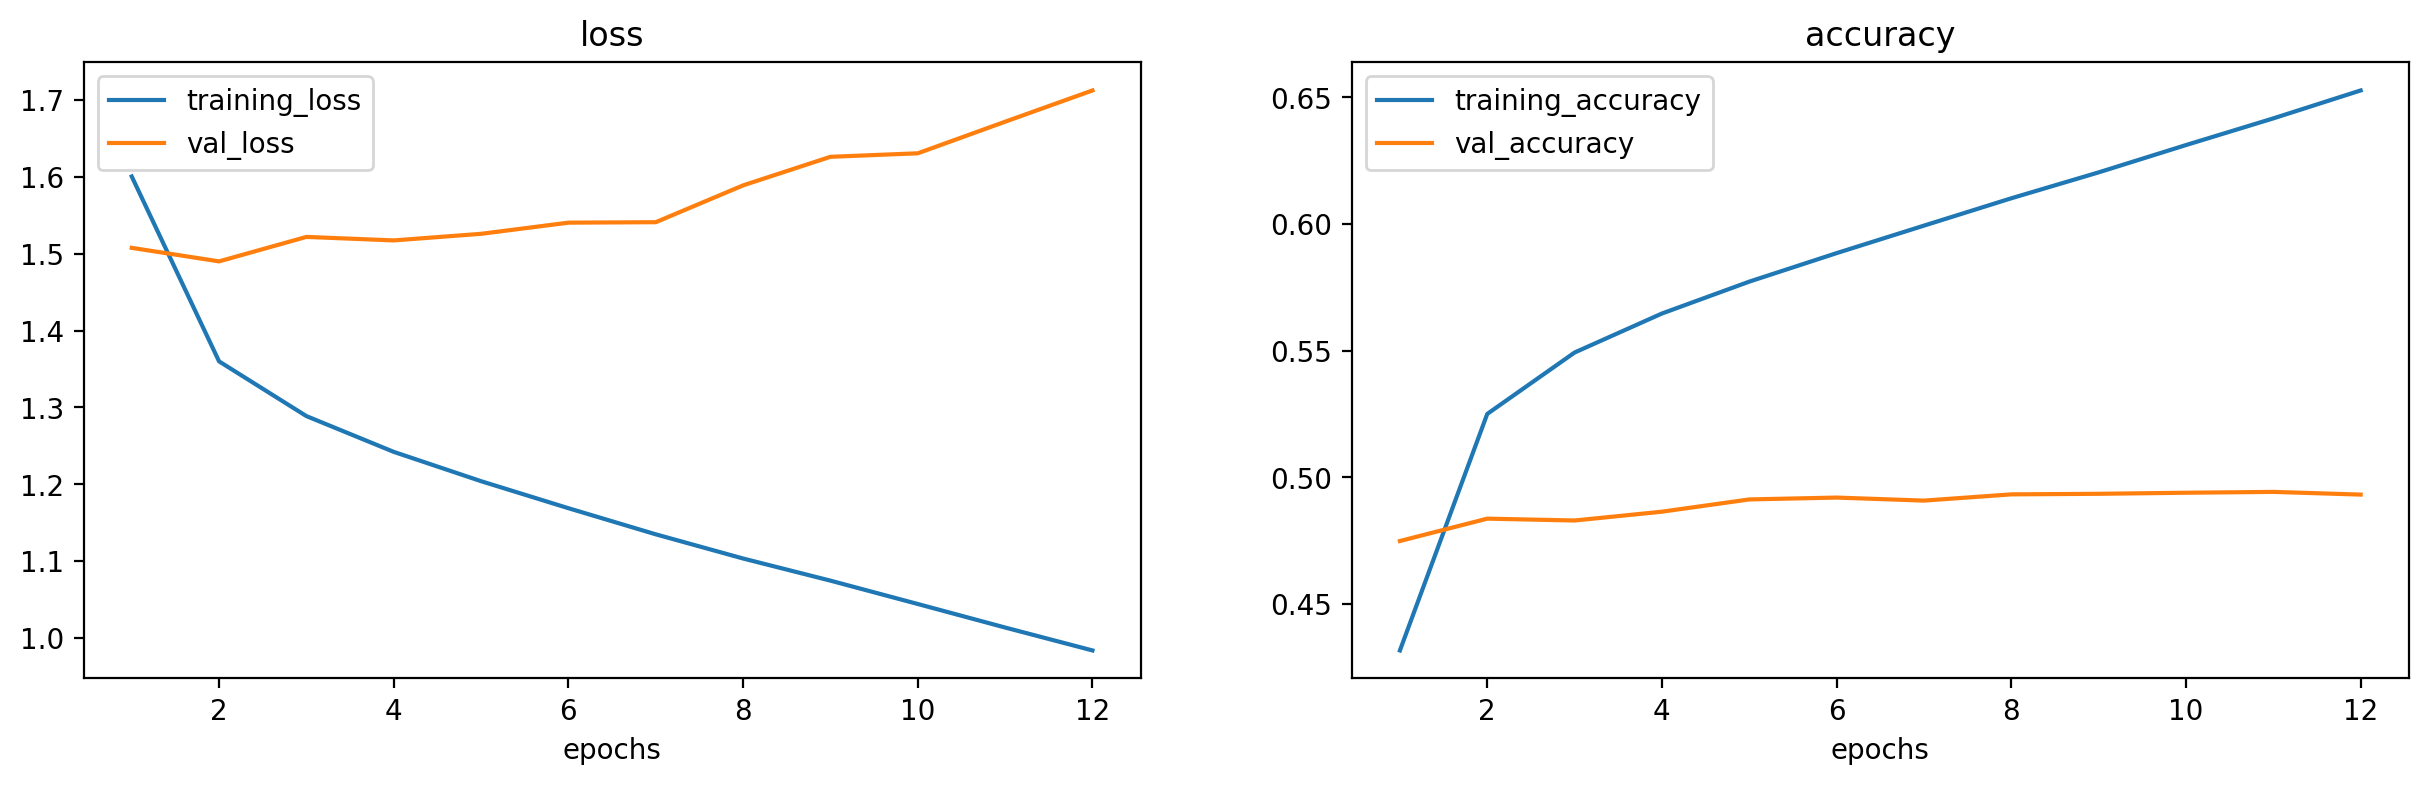

In [48]:
plot_loss_curves(history_4)
# upload_plot('model_4_plot_loss')

## Result Analysis

In [49]:
def how_is_confused(model, data, labels):
    """
    Analyzes a model's predictions to identify which classes are most frequently misclassified.

    This function takes a trained model, data, and true labels, and computes the model's predictions. It identifies the instances 
    where the model's predictions do not match the true labels and calculates the frequency of misclassifications for each class. 
    It then returns a DataFrame with the total number of instances, the number of wrong predictions, and the percentage of 
    misclassifications for each class, sorted by the percentage of misclassifications in descending order.

    Parameters:
    - model: The trained model to evaluate.
    - data: The input data on which the model makes predictions.
    - labels: The true labels corresponding to the input data.

    Returns:
    - final (pandas.DataFrame): A DataFrame with columns 'Total', 'Wrong', and 'Perc', representing the total number of instances, 
    number of wrong predictions, and percentage of misclassifications for each class, respectively.
    """

    preds = np.argmax(model.predict(data), axis=1)
    
    wrong_preds_idx = np.where(preds != labels)
    wrong_preds_labels = preds[wrong_preds_idx]
    df_wrong_total = pd.Series(Counter(wrong_preds_labels))
    
    df_total = labels.value_counts()
    final = pd.concat([df_total, df_wrong_total], axis=1)
    final.columns = ['Total', 'Wrong']
    final['Perc'] = final['Wrong'] / final['Total'] * 100
    final = final.sort_values(by='Perc', ascending=False)
    return final

how_is_confused(model_1, test_sentences_vectorized, test_labels)

2024-04-30 05:41:37.214473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-30 05:41:37.217285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-30 05:41:37.219231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1409/1409 [==============================] - 5s 3ms/step


,Total,Wrong,Perc
6.0,9989,9470,94.804285
3.0,7919,5958,75.236772
8.0,3679,2053,55.803207
0.0,4568,2152,47.110333
5.0,3000,1255,41.833333
7.0,5344,2165,40.512725
9.0,3394,903,26.605775
1.0,2067,514,24.866957
2.0,2964,374,12.618084
4.0,2143,74,3.453103


In [50]:
def where_is_confused(model, data, target, labels, preds):
    """
    Identifies the distribution of predicted classes for a specific true class, highlighting where a model may be confused.

    This function calculates where a trained model tends to misclassify instances of a specific true class. It filters the instances
    where the true class matches the specified target class, then analyzes the predictions for these instances to see how they
    are distributed across different predicted classes. This helps in understanding the model's confusion regarding the target
    class.

    Parameters:
    - model: The trained model used for prediction. (Note: The parameter 'model' is not used in the function and can be removed.)
    - data: The input data on which predictions were made.
    - target: The specific true class for which we want to analyze the predictions.
    - labels: The true labels for the input data.
    - preds: The predicted labels for the input data.

    Returns:
    - A pandas Series containing the count of predictions for each class where the true label is the specified target class.
    """

    true_target_preds = np.where(target == labels)
    return pd.Series(Counter(preds[true_target_preds]))

def create_confusion(model, data, labels):
    """
    Constructs a detailed confusion matrix DataFrame showing misclassification counts for each class pair.

    This function predicts class labels for the given data using the provided model, and then analyzes where the model is 
    confused by comparing the predictions with the true labels. It constructs a confusion matrix where each cell (i, j) 
    indicates how many times the model predicted class j for instances that are actually of class i. This detailed confusion 
    matrix helps in understanding the model's performance across different classes.

    Parameters:
    - model: The trained model to be evaluated.
    - data: The dataset (features) on which predictions are to be made.
    - labels: The true labels of the data.

    Returns:
    - df_confusion (pandas.DataFrame): A DataFrame representing the detailed confusion matrix. Rows represent the true classes, 
    and columns represent the predicted classes.
    """

    preds = np.argmax(model.predict(data), axis=1)
    series_dict = {i: where_is_confused(model, data, i, labels, preds) for i in range(10)}
    df_confusion = pd.DataFrame(series_dict)
    df_confusion.fillna(0, inplace=True)
    df_confusion.index = id2label
    df_confusion.columns = id2label
    return df_confusion

df_confusion = create_confusion(model_4, test_sentences_vectorized, test_labels)
df_confusion

1409/1409 [==============================] - 6s 4ms/step


,0,1,2,3,4,5,6,7,8,9
0,1766,98,368,423,362,305,601,270,532,235
1,27,994,40,37,20,32,87,46,51,21
2,118,51,1069,94,38,85,117,76,113,46
3,679,125,319,5242,334,234,809,482,331,733
4,120,9,43,90,662,35,90,46,54,29
5,292,67,146,188,127,1314,405,187,407,96
6,863,462,526,999,362,523,6335,2010,508,409
7,189,111,125,302,68,85,1075,1914,93,311
8,382,133,268,245,111,330,327,153,1537,119
9,132,17,60,299,59,57,143,160,53,1395


In [ ]:
id2label